Data from the experiment on 2021/05/06: this file puts data in channels * cycles * z * y * x

# Preprocessing

In [1]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
import tifffile as tif
import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage
import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting

In [2]:
n_channels = 2
n_cycles = 5

img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle0.tiff')
img_size = img.shape[:2]

X = np.zeros((n_channels*n_cycles, 1, *img_size))
k = 0
for i in range(n_channels):
    for j in range(n_cycles):
        fn = f'./data/crisprmap20210506/amp-ch{i+1}-cycle{j}.tiff'
        print(fn)
        img = tif.imread(fn)
        X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
        k = k+1

./data/crisprmap20210506/amp-ch1-cycle0.tiff
./data/crisprmap20210506/amp-ch1-cycle1.tiff
./data/crisprmap20210506/amp-ch1-cycle2.tiff
./data/crisprmap20210506/amp-ch1-cycle3.tiff
./data/crisprmap20210506/amp-ch1-cycle4.tiff
./data/crisprmap20210506/amp-ch2-cycle0.tiff
./data/crisprmap20210506/amp-ch2-cycle1.tiff
./data/crisprmap20210506/amp-ch2-cycle2.tiff
./data/crisprmap20210506/amp-ch2-cycle3.tiff
./data/crisprmap20210506/amp-ch2-cycle4.tiff


In [3]:
img.shape

(2048, 1792, 4)

In [4]:
X.shape

(10, 1, 2048, 1792)

In [5]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

In [6]:
# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle2.tiff')
# plt.figure(dpi=100)
# plt.imshow(img[80:100, 80:100, 1])
# plt.axis('image')
# # im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

In [7]:
up = 10
down = 1900
left = 50
right = 1650

Xcenter = X[:, :, up:down, left:right] # range is selected based on observation of images

In [8]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

# Codebook

The most important is to make sure the codebook and the images are of the same order

In [9]:
# !! currently the first value shows nan and hard code it to be 1; needs a better fix
codebook = np.genfromtxt('./data/CRISPRmap_pilot_codebook_default.csv', filling_values=1, dtype=np.int, delimiter=",")
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [10]:
# codebook = csv.reshape((10, 2, 5)).T.astype(bool)
# codebook

In [11]:
codebook.shape

(10, 10)

The order of the codebook matches the order of the image stack.

## Background subtraction and normalization

In [12]:
Xcenter.shape

(10, 1, 1890, 1600)

In [13]:
# Different from how bardensr did it (use these functions for now because they are tested)
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [14]:
Xnorm.shape

(10, 1, 1890, 1600)

In [15]:
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xnorm[i, 0,])

## Distribution

In [16]:
# # create the histogram
# for i in range(Xnorm.shape[0]):
#     histogram, bin_edges = np.histogram(Xnorm[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

## Thresholding

In [17]:
Xnorm.shape

(10, 1, 1890, 1600)

In [18]:
Xnorm[0, 0,].shape

(1890, 1600)

In [19]:
# upper = 0.9
# lower = [0.2, 0.16, 0.13, 0.15, 0.16, 0.16, 0.16, 0.13, 0.15, 0.15]
# Xthresh = Xnorm.copy()
# for i in range(Xthresh.shape[0]):
#     single = Xthresh[i, 0,]
#     single[single < lower[i]] = 0
#     single[single > upper] = upper
#     Xthresh[i, 0] = single

In [20]:
residual = 0.125  # tested through the spot method and the cell method should be less sensitive 
Xthresh = Xnorm.copy()
Xthresh[Xthresh < residual] = 0

In [21]:
# for i in range(Xthresh.shape[0]):
#     histogram, bin_edges = np.histogram(Xthresh[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

In [22]:
# # Before and after (partial region)
# # with bardensr.plotting.AnimAcross() as a:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=250)
#     plt.subplot(1, 2, 1)
# #     a('before')
#     plt.imshow(Xnorm[i, 0, 200:500, 200:500])
#     plt.subplot(1, 2, 2)
# #     a('after')
#     plt.imshow(Xthresh[i, 0, 200:500, 200:500])

# Peak calling and counting (inside membrane masks)

**Check by overlay to see if there are enough spots called.**

In [23]:
# Read in the membrane segmentation
hf = h5py.File("./data/Ben_MembraneSegmentation_NuclearGFP_2021-06-22.hdf5", "r")
print(hf.keys())
masks_mem = hf["Cell Seg Mask"]

<KeysViewHDF5 ['Average GFP Masks', 'Cell Seg Mask', 'Max Projection', 'Nuc Seg Mask', 'Summed GFP Masks']>


In [24]:
# plt.figure(dpi=250)
# plt.imshow(masks_mem)
# plt.axis('image')

In [25]:
# Find the number of membrane segmentation masks
# np.unique(masks_mem)

In [26]:
# # Check starting from which number the masks are truly membrane segmentation (instead of the background)
# plt.figure(dpi=300)
# for i in range(0, 5):
#     plt.figure()
#     plt.imshow(np.array(masks_mem)==i)

In [27]:
#     xindex = test.loc[i, 'm2'] + left
#     yindex = test.loc[i, 'm1'] + up

In [28]:
# pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))

In [29]:
# cell_table = pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))
cell_table = np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0]))

for k in range(Xthresh.shape[0]):  # for the kth image
    # Get local maximum values of desired neighborhood (size of the amplicons)
    max_fil = ndimage.maximum_filter(Xthresh[k,], size=(1, 2, 2))

    # Threshold the image to find locations of interest
    # assuming 6 standard deviations above the mean of the image
    peak_thresh = max_fil.mean() + max_fil.std() * 6

    # find areas greater than peak_thresh
    labels, num_labels = ndimage.label(max_fil > peak_thresh)

    # Get the positions of the maxima
    coords = ndimage.measurements.center_of_mass(Xthresh[k,], 
                                                 labels=labels, 
                                                 index=np.arange(1, num_labels + 1))

    # # Get the maximum value in the labels
    # values = ndimage.measurements.maximum(img, labels=labels, index=np.arange(1, num_labels + 1))
    # # https://stackoverflow.com/questions/55453110/how-to-find-local-maxima-of-3d-array-in-python

    for _, m1, m2 in coords:
        m1 = int(np.round(m1))
        m2 = int(np.round(m2))
        mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
        if mem_id>0: # 0 is background
#             cell_table.loc[mem_id, k] += 1
            cell_table[mem_id, k] += 1

In [30]:
# labels

In [59]:
num_labels

299

In [32]:
coords[:10]

[(0.0, 6.543602130081081, 861.0),
 (0.0, 8.0, 108.59272456891979),
 (0.0, 9.481436771695659, 903.0),
 (0.0, 11.254144676468409, 729.667745198682),
 (0.0, 14.440051349491345, 1046.6361900533907),
 (0.0, 14.434706722909056, 1560.5603333633226),
 (0.0, 30.0, 542.0),
 (0.0, 30.435710348342994, 854.9999999999999),
 (0.0, 34.46947260290432, 990.7079067808304),
 (0.0, 34.362508995111035, 1529.6088846841628)]

In [33]:
int(np.round(801.5228444869555))

802

In [34]:
len(coords)

299

In [60]:
pd.DataFrame(cell_table)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
655,20.0,4.0,1.0,0.0,0.0,10.0,3.0,8.0,0.0,1.0
656,1.0,17.0,0.0,0.0,0.0,2.0,1.0,18.0,0.0,0.0
657,2.0,8.0,1.0,0.0,0.0,5.0,0.0,2.0,1.0,0.0
658,0.0,1.0,9.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0


In [36]:
cell_table.shape

(660, 10)

# Nearest Neighbor/Correlation

In [37]:
# Calculate the correlation
cell_norm = np.sqrt(np.sum(np.power(cell_table, 2), axis=1))
cell_corr = cell_table.dot(codebook.T) / np.reshape(cell_norm + 1e-6, (-1,1))  # add 1e-6 to avoid the denominator being 0

In [38]:
cell_corr[200:205,]

array([[1.38873008, 0.        , 0.10286889, 0.05143445, 0.20573779,
        0.77151671, 0.8743856 , 0.72008226, 0.20573779, 0.10286889],
       [0.64326749, 0.        , 0.05360562, 0.        , 0.91129561,
        0.16081687, 0.2144225 , 0.53605624, 0.10721125, 0.85768998],
       [0.04944682, 0.09889363, 0.09889363, 0.        , 0.9889363 ,
        0.14834045, 1.03838312, 0.        , 0.9889363 , 0.09889363],
       [1.38873004, 0.        , 0.15430334, 0.        , 0.        ,
        0.77151669, 0.61721335, 0.77151669, 0.        , 0.15430334],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [39]:
cell_corr.shape

(660, 10)

In [40]:
# cell_norm + 1e-6

In [41]:
# (cell_table.dot(codebook.T) / np.reshape(cell_norm, (-1,1))).shape

In [42]:
# cell_norm

In [43]:
# np.reshape(cell_norm, (-1,1))

In [74]:
# Assign cells to barcodes according to the max correlation
cell_id = pd.DataFrame(np.argmax(cell_corr, axis=1), columns=['barcode'])
cell_id

,barcode
0,0
1,0
2,4
3,0
4,0
...,...
655,0
656,9
657,5
658,4


In [45]:
# cell_id.loc[200:210]

In [46]:
# cell_id.to_csv('./result/crisprmap20210506_layer1out0123_cell_id_thresh6std.csv', index=False)

In [47]:
heapq.nlargest(2, cell_corr[116,])

[1.183215756619957, 1.183215756619957]

In [48]:
def minmax(x, min_all, max_all):
    y = (x-min_all)/max_all
    return y

In [75]:
cell_id['max'] = minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['second_max'] = minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
# cell_id['second_max'] = [heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index]
cell_id['quality'] = cell_id['max'] - cell_id['second_max']
cell_id['spots'] = np.sum(cell_table, axis=1)
# cell_id = cell_id.sort_values(by=['quality'], ascending=False)
cell_id

,barcode,max,second_max,quality,spots
0,0,0.000000,0.000000,0.000000,0.0
1,0,0.000000,0.000000,0.000000,0.0
2,4,0.852803,0.852803,0.000000,5.0
3,0,0.000000,0.000000,0.000000,0.0
4,0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...
655,0,0.872595,0.668989,0.203605,47.0
656,9,0.994736,0.539999,0.454736,39.0
657,5,0.923870,0.710669,0.213201,19.0
658,4,0.993146,0.574979,0.418167,21.0


In [76]:
# cell_id.head(40)

In [67]:
pd.DataFrame(cell_table).loc[406,]

0    0.0
1    0.0
2    0.0
3    4.0
4    0.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: 406, dtype: float64

In [69]:
np.sum(cell_table, axis=1).shape

(660,)

In [80]:
cell_id.sort_values(by=['spots'], ascending=False).head(20)

,barcode,max,second_max,quality,spots
555,4,0.998070,0.528892,0.469178,125.0
125,4,0.757896,0.708198,0.049698,117.0
504,8,0.875905,0.841779,0.034126,108.0
405,6,0.958857,0.620437,0.338420,106.0
604,6,0.953074,0.673367,0.279706,103.0
328,6,0.840318,0.713477,0.126840,95.0
443,6,0.967186,0.636927,0.330259,94.0
306,9,0.939793,0.740443,0.199350,90.0
550,8,0.862507,0.847636,0.014871,89.0
379,6,0.896262,0.687544,0.208719,85.0


In [81]:
cell_id.sort_values(by=['quality'], ascending=False).head(20)

,barcode,max,second_max,quality,spots
291,1,0.938876,0.000000,0.938876,60.0
406,1,0.857493,0.000000,0.857493,5.0
359,1,0.923846,0.074906,0.848940,40.0
98,1,0.920358,0.076696,0.843661,26.0
156,1,0.925711,0.100987,0.824724,67.0
118,1,0.925208,0.102801,0.822407,43.0
83,1,0.904194,0.082199,0.821995,12.0
283,1,0.920980,0.099565,0.821414,43.0
299,1,0.927498,0.132500,0.794998,42.0
380,1,0.880812,0.091119,0.789694,36.0


<AxesSubplot:xlabel='quality', ylabel='Count'>

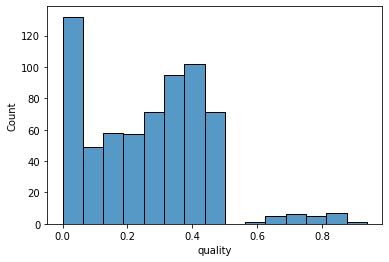

In [50]:
import seaborn as sns
sns.histplot(data=cell_id, x="quality")

<AxesSubplot:xlabel='max', ylabel='Count'>

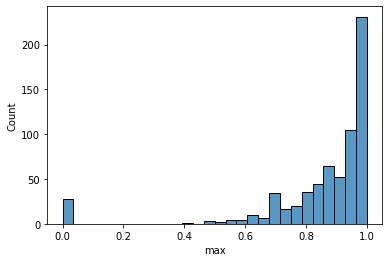

In [51]:
import seaborn as sns
sns.histplot(data=cell_id, x="max")

<AxesSubplot:xlabel='second_max', ylabel='Count'>

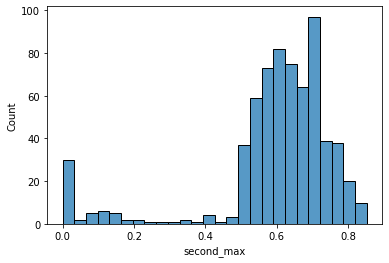

In [52]:
import seaborn as sns
sns.histplot(data=cell_id, x="second_max")

In [53]:
cell_id[cell_id['quality']>0.7]

,barcode,max,second_max,quality
291,1,0.938876,0.000000,0.938876
406,1,0.857493,0.000000,0.857493
359,1,0.923846,0.074906,0.848940
98,1,0.920358,0.076696,0.843661
156,1,0.925711,0.100987,0.824724
118,1,0.925208,0.102801,0.822407
83,1,0.904194,0.082199,0.821995
283,1,0.920980,0.099565,0.821414
299,1,0.927498,0.132500,0.794998
380,1,0.880812,0.091119,0.789694


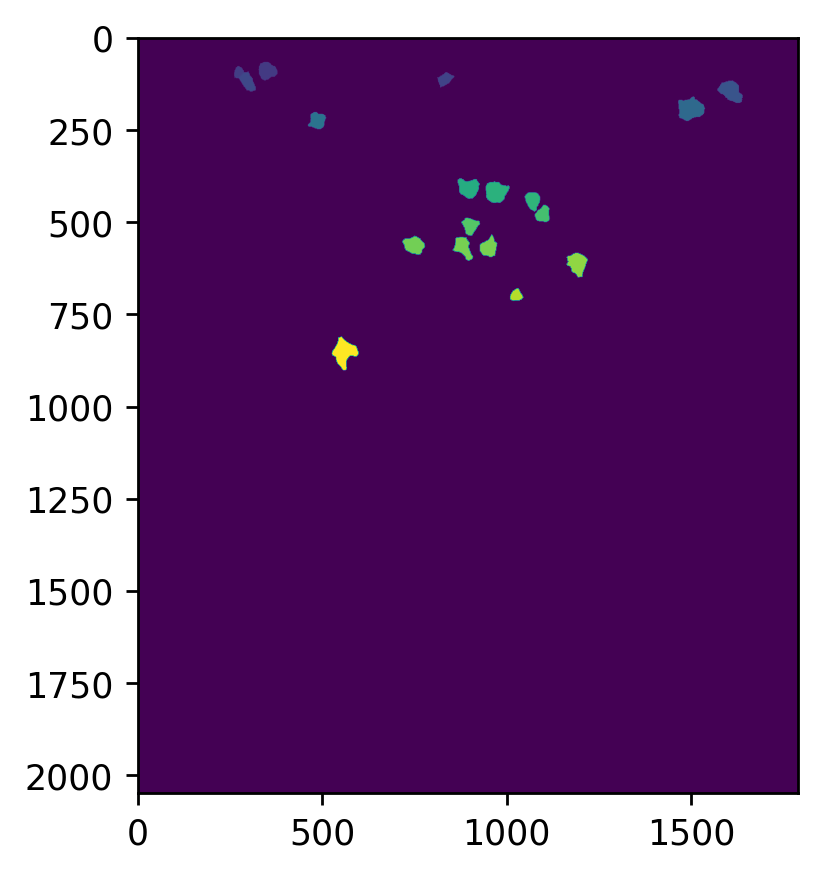

In [54]:
# Possibly plot which cells have high quality scores
high_quality = cell_id[cell_id['quality']>0.7]
high_quality_mem = np.zeros(masks_mem.shape)
for i in high_quality.index:
    high_quality_mem[np.array(masks_mem)==i] = i
plt.figure(dpi=250)
plt.imshow(high_quality_mem)

In [55]:
# sns.histplot(data=cell_id, x="max")

In [82]:
# set(cell_id['max'])

In [57]:
np.max(cell_corr)

1.4142134909445272

In [58]:
cell_corr.shape

(660, 10)

<AxesSubplot:xlabel='spots', ylabel='Count'>

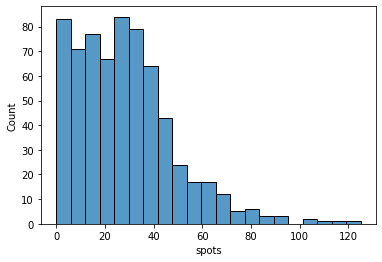

In [83]:
sns.histplot(data=cell_id, x="spots")

<!-- list1 = [10, 20, 4, 45, 99]
 
# new_list is a set of list1
new_list = set(list1)
 
# removing the largest element from temp list
new_list.remove(max(new_list))
 
# elements in original list are not changed
# print(list1)
 
print(max(new_list)) -->